# Plot state evolution to test output pulses in lab frame, linearly interpolated to generate fine enough time step

<KeysViewHDF5 ['H0', 'Hnames', 'Hops', 'U', 'convergence', 'error', 'initial_guess', 'initial_vectors_c', 'inter_vecs_imag', 'inter_vecs_mag_squared', 'inter_vecs_raw_imag', 'inter_vecs_raw_real', 'inter_vecs_real', 'iteration', 'maxA', 'method', 'reg_coeffs', 'reg_error', 'run_time', 'sparse_H', 'sparse_K', 'sparse_U', 'states_concerned_list', 'steps', 'taylor_scaling', 'taylor_terms', 'total_time', 'uks', 'unitary_scale', 'use_gpu', 'wall_clock_time']>
[b'xi0' b'yi0' b'xi1' b'yi1' b'xi2' b'yi2' b'fg1x' b'fg1y']
no collapse operator, using sesolve
no collapse operator, using sesolve
0.9997620859288878
0.00023791407111217744
0.9997717756304215
0.00022822436957847803


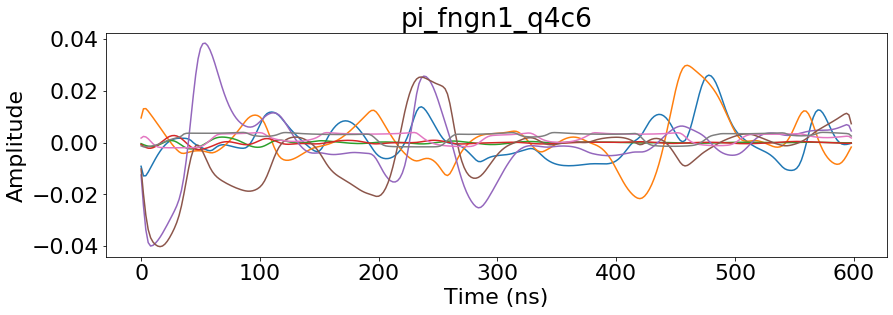

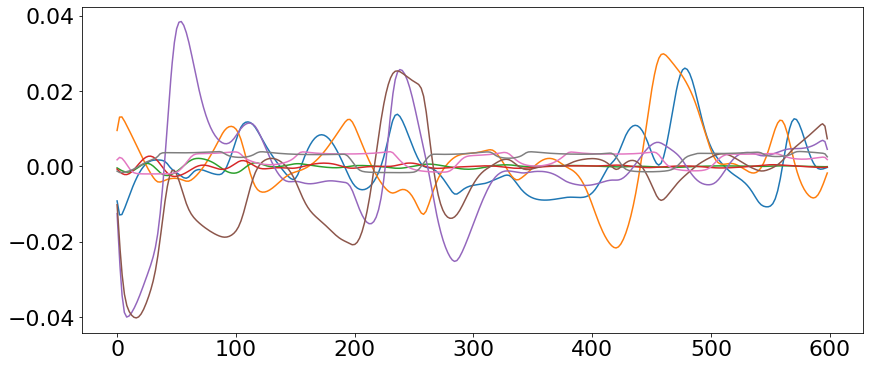

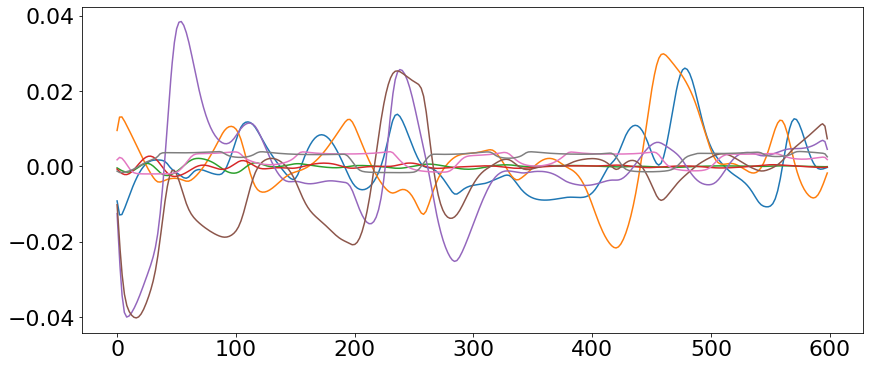

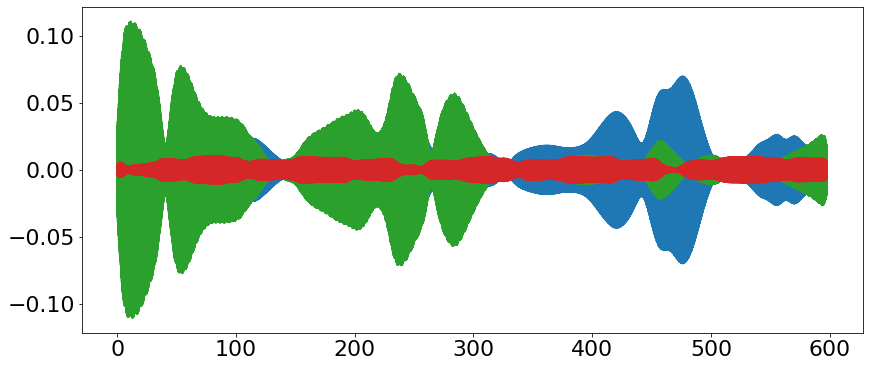

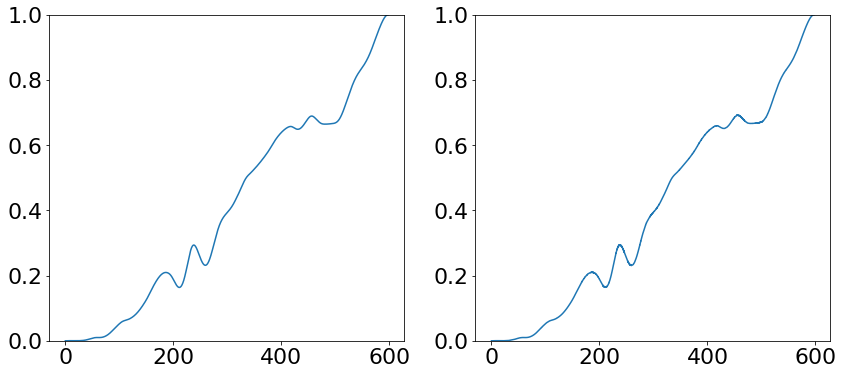

In [26]:
%matplotlib inline
import numpy as np
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
from qutip import *
from scipy import interpolate


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
from slab.dsfit import*
import json


expt_name = 'binomialcode_pi_fngn1'
expt_name = 'pi_fngn1_q4c6'
filelist = [21] 
nus = []


def labH(q_num, m_num, start_state, end_states, f, ROTATING):
    global fig_counter
    # Defining time scales, other parameters for lab drift Hamiltonian H0
    total_time = f['total_time'][()]
    steps = f['steps'][()]
    fine_steps = 30000
    base_times = np.arange(steps) * total_time / steps
    # subtract off the last step to not have fine_step times greater than the maximum base_time
    tlist = np.arange(fine_steps - fine_steps/steps) * total_time / fine_steps
    
    qubit_state_num = q_num
    alpha = 0.139
    freq_ge = 4.8 # GHz, in lab frame
    ens = np.array([2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
    Q_x = np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1)+np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1)
    Q_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1)-np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1))
    Q_z = np.diag(np.arange(0, qubit_state_num))
    I_q = np.identity(qubit_state_num)
    H_q = np.diag(ens)

    mode_state_num = m_num
    chi = -0.565e-3
    kappa = -chi / 10.0
    if ROTATING:
        mode_freq = 0.0  # GHz, in rotating frame
    else:
        mode_freq = 6.0  # GHz, in lab frame
    mode_ens = np.array([2*np.pi*ii*(mode_freq - 0.5*(ii-1)*kappa) for ii in np.arange(mode_state_num)])
    M_x = np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)+np.diag(np.sqrt(np.arange(1, mode_state_num)), -1)
    M_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)-np.diag(np.sqrt(np.arange(1, mode_state_num)), -1))
    M_z = np.diag(np.arange(0, mode_state_num))
    H_m = np.diag(mode_ens)
    I_m = np.identity(mode_state_num)

    # drift Hamiltonian (definition different in rotating vs. lab frame)
    if ROTATING:  # rotating frame Hamiltonian
        H0 = Qobj(np.kron(I_q, H_m) + 2 * 2 * np.pi * chi * np.kron(Q_z, M_z))  
    else:  # lab Hamiltonian
        H0 = Qobj(np.kron(H_q, I_m) + np.kron(I_q, H_m) + 2 * 2 * np.pi * chi * np.kron(Q_z, M_z))
    

    
    # define control Hamiltonians (definition may be different in rotating vs. lab frame)
    controlHs = []
    # qubit Pi pulses
    for state in range(qubit_state_num - 1):
        piX = np.zeros((qubit_state_num, qubit_state_num))
        piY = np.zeros((qubit_state_num, qubit_state_num)) * 1j
        piX[state][state + 1] = 1.0
        piX[state + 1][state] = 1.0
        piY[state][state + 1] = 0 + 1j
        piY[state + 1][state] = 0 - 1j
        controlHs.append(Qobj(np.kron(piX, I_m)))  # only have x-pulses in lab frame
        if ROTATING:
            controlHs.append(Qobj(np.kron(piY, I_m)))
    
    # fn-g(n+1) sideband
    fngnp1x = np.zeros((qubit_state_num * mode_state_num, qubit_state_num * mode_state_num))
    fngnp1y = np.zeros((qubit_state_num * mode_state_num, qubit_state_num * mode_state_num)) * 1j
    for n in range(mode_state_num - 1):
        fngnp1x[n+1][n+2*mode_state_num] = np.sqrt(n+1)
        fngnp1x[n+2*mode_state_num][n+1] = np.sqrt(n+1)
        fngnp1y[n+1][n+2*mode_state_num] = 1j * np.sqrt(n+1)
        fngnp1y[n+2*mode_state_num][n+1] = -1j * np.sqrt(n+1)
    controlHs.append(Qobj(fngnp1x))  # only have x-pulses in lab frame
    if ROTATING:
        controlHs.append(Qobj(fngnp1y))
    
    # put together drift and control Hamiltonians
    fig2 = plt.figure(fig_counter, figsize=(14,6))
    fig_counter += 1
    fine_pulses = []
    if ROTATING:
        for i in range(len(controlHs)):
            base_pulse = f['uks'][-1][i]  # final control pulse
            interpFun = interpolate.interp1d(base_times, base_pulse)
            pulse_interp = interpFun(tlist)
            fine_pulses.append(pulse_interp)
            plt.plot(tlist, pulse_interp)
    else:
        for i in range(2 * len(controlHs)):
            base_pulse = f['uks'][-1][i]  # final control pulse
            interpFun = interpolate.interp1d(base_times, base_pulse)
            pulse_interp = interpFun(tlist)
            fine_pulses.append(pulse_interp)
            plt.plot(tlist, pulse_interp)
    # fig2.show()
    
    if ROTATING:
        H = [H0]
        for index in range(len(fine_pulses)):
            H.append([controlHs[index], fine_pulses[index]])
    else:
        scale = 2
        # pi_ge qubit pulse
        amps_ge = scale * (fine_pulses[0] * np.cos(tlist * 2*np.pi * freq_ge) - \
                  fine_pulses[1] * np.sin(tlist * 2*np.pi* freq_ge))

        # pi_ef qubit pulse
        amps_ef = scale * (fine_pulses[2] * np.cos(tlist * 2*np.pi * (freq_ge - alpha)) - \
                  fine_pulses[3] * np.sin(tlist * 2*np.pi * (freq_ge - alpha)))

        # pi_fh qubit pulse
        amps_fh = scale * (fine_pulses[4] * np.cos(tlist * 2*np.pi * (freq_ge - 2 * alpha)) - \
                  fine_pulses[5] * np.sin(tlist * 2*np.pi * (freq_ge - 2 * alpha)))

        # fng(n+1) sideband pulse
        amps_fngn1 = scale * (fine_pulses[6] * np.cos(tlist * 2*np.pi * (2 * freq_ge - alpha - mode_freq)) - \
                        fine_pulses[7] * np.sin(tlist * 2*np.pi * (2 * freq_ge - alpha - mode_freq)))

        fig3 = plt.figure(fig_counter, figsize=(14,6))
        fig_counter += 1
        plt.plot(tlist, amps_ge)
        plt.plot(tlist, amps_ef)
        plt.plot(tlist, amps_fh)
        plt.plot(tlist, amps_fngn1)
        # fig3.show()

        H = [H0, [controlHs[0], amps_ge], [controlHs[1], amps_ef], [controlHs[2], amps_fh], [controlHs[3], amps_fngn1]]

    # starting state
    rho0 = start_state
    
    # define expectation values to look at
    e_ops = []
    for state in end_states:
        e_op = Qobj(np.diag(end_states))
        e_ops.append(e_op)
    result = mesolve(H, rho0, tlist, c_ops=[], e_ops=e_ops)
    #result_states = mesolve(H, rho0, tlist, c_ops=[], e_ops=[])
    return result, tlist


fig_counter = 1

for ii,i in enumerate(filelist):
    filename = "C:\Schuster Lab\Multimode\GRAPE-Tensorflow-Examples-master\pulses\output_pulses\\" + \
                str(i).zfill(5) + "_" + expt_name.lower()+".h5"

    with File(filename,'r') as a:
        print(a.keys())
        # get values that will be used in plotting
        # get scalar slice using [()]
        update_step = a['convergence']['update_step'][()]
        steps = a['steps'][()]
        dt = a['total_time'][()] / steps
        #print(a['wall_clock_time'][()])
        
        fig = plt.figure(1, figsize=(14,14))
        fig_counter += 1
        ax = fig.add_subplot(311, title=expt_name)
    
        # plot control pulses, last element is the final control pulse output
        for i in range(len(a['Hops'][()])):
            ax.plot(np.arange(0, steps) * dt, a['uks'][-1][i])
        #ax.plot(np.arange(0, steps) * dt, np.zeros(steps), '--k')  # plot a line y=0 for reference
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Amplitude")
        print(a['Hnames'][()])
        
        qubit_state_num = 4
        mode_state_num = 6
        
        start_state = np.zeros(qubit_state_num * mode_state_num)  # 4 qubit states, 6 cavity states
        start_state[1] = 1.0  # g1
        start_state = Qobj(start_state)

        f0 = np.zeros(qubit_state_num * mode_state_num)
        f0[2 * mode_state_num] = 1
        end = f0
        output, tlist = labH(qubit_state_num, mode_state_num, start_state, end, a, True)
        output_rot, tlist_rot = labH(qubit_state_num, mode_state_num, start_state, end, a, False)
        fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(14,6))
        ax.plot(tlist, output.expect[0], label="f0")
        ax2.plot(tlist_rot, output_rot.expect[0], label="f0_rot")
        ax.set_ylim(0, 1)
        ax2.set_ylim(0, 1)
        print(output.expect[0][-1])
        print(str(1 - output.expect[0][-1]))
        print(output_rot.expect[0][-1])
        print(str(1 - output_rot.expect[0][-1]))
    
    


# Same code as above, just testing a different state

<KeysViewHDF5 ['H0', 'Hnames', 'Hops', 'U', 'convergence', 'error', 'initial_guess', 'initial_vectors_c', 'inter_vecs_imag', 'inter_vecs_mag_squared', 'inter_vecs_raw_imag', 'inter_vecs_raw_real', 'inter_vecs_real', 'iteration', 'maxA', 'method', 'reg_coeffs', 'reg_error', 'run_time', 'sparse_H', 'sparse_K', 'sparse_U', 'states_concerned_list', 'steps', 'taylor_scaling', 'taylor_terms', 'total_time', 'uks', 'unitary_scale', 'use_gpu', 'wall_clock_time']>
[b'xi0' b'yi0' b'xi1' b'yi1' b'xi2' b'yi2' b'fg1x' b'fg1y']
no collapse operator, using sesolve
no collapse operator, using sesolve
0.9997857653766999
0.00021423462330005805
0.9954277696671203
0.004572230332879679


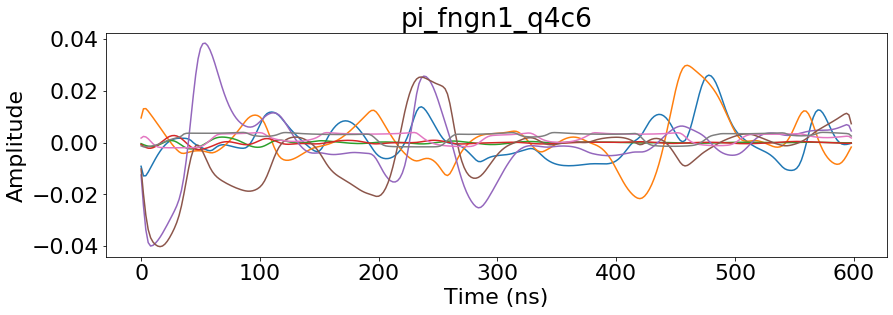

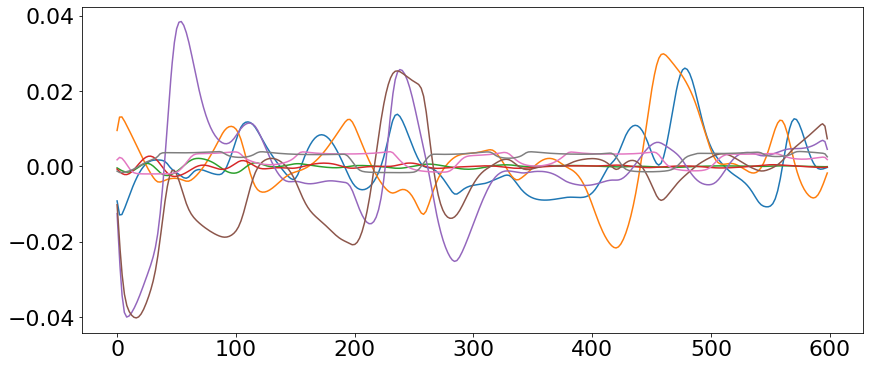

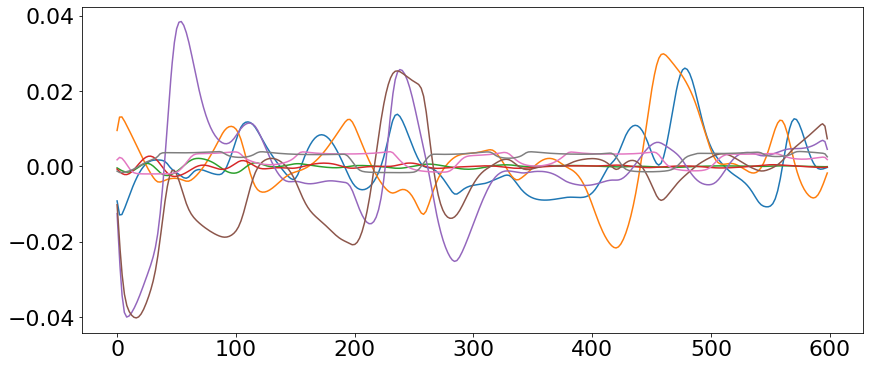

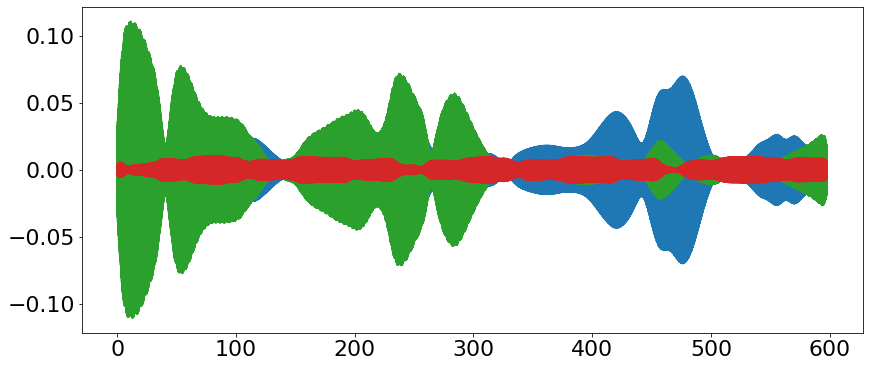

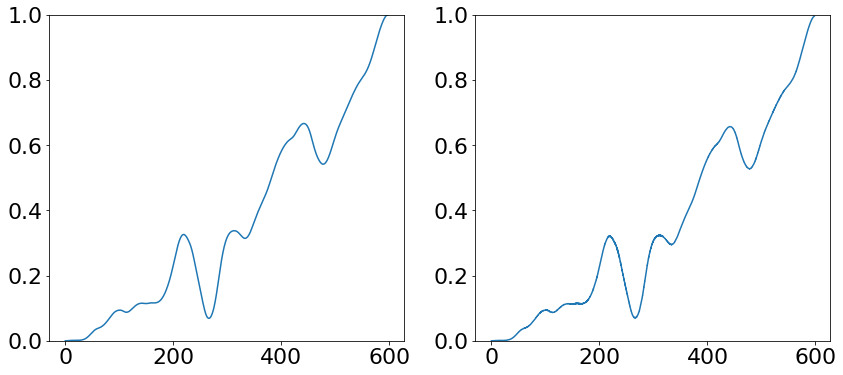

In [27]:
%matplotlib inline
import numpy as np
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
from qutip import *
from scipy import interpolate


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
from slab.dsfit import*
import json


expt_name = 'binomialcode_pi_fngn1'
expt_name = 'pi_fngn1_q4c6'
filelist = [21] 
nus = []


def labH(q_num, m_num, start_state, end_states, f, ROTATING):
    global fig_counter
    # Defining time scales, other parameters for lab drift Hamiltonian H0
    total_time = f['total_time'][()]
    steps = f['steps'][()]
    fine_steps = 30000
    base_times = np.arange(steps) * total_time / steps
    # subtract off the last step to not have fine_step times greater than the maximum base_time
    tlist = np.arange(fine_steps - fine_steps/steps) * total_time / fine_steps
    
    qubit_state_num = q_num
    alpha = 0.139
    freq_ge = 4.8 # GHz, in lab frame
    ens = np.array([2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
    Q_x = np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1)+np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1)
    Q_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1)-np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1))
    Q_z = np.diag(np.arange(0, qubit_state_num))
    I_q = np.identity(qubit_state_num)
    H_q = np.diag(ens)

    mode_state_num = m_num
    chi = -0.565e-3
    kappa = -chi / 10.0
    if ROTATING:
        mode_freq = 0.0  # GHz, in rotating frame
    else:
        mode_freq = 6.0  # GHz, in lab frame
    mode_ens = np.array([2*np.pi*ii*(mode_freq - 0.5*(ii-1)*kappa) for ii in np.arange(mode_state_num)])
    M_x = np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)+np.diag(np.sqrt(np.arange(1, mode_state_num)), -1)
    M_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)-np.diag(np.sqrt(np.arange(1, mode_state_num)), -1))
    M_z = np.diag(np.arange(0, mode_state_num))
    H_m = np.diag(mode_ens)
    I_m = np.identity(mode_state_num)

    # drift Hamiltonian (definition different in rotating vs. lab frame)
    if ROTATING:  # rotating frame Hamiltonian
        H0 = Qobj(np.kron(I_q, H_m) + 2 * 2 * np.pi * chi * np.kron(Q_z, M_z))  
    else:  # lab Hamiltonian
        H0 = Qobj(np.kron(H_q, I_m) + np.kron(I_q, H_m) + 2 * 2 * np.pi * chi * np.kron(Q_z, M_z))
    

    
    # define control Hamiltonians (definition may be different in rotating vs. lab frame)
    controlHs = []
    # qubit Pi pulses
    for state in range(qubit_state_num - 1):
        piX = np.zeros((qubit_state_num, qubit_state_num))
        piY = np.zeros((qubit_state_num, qubit_state_num)) * 1j
        piX[state][state + 1] = 1.0
        piX[state + 1][state] = 1.0
        piY[state][state + 1] = 0 + 1j
        piY[state + 1][state] = 0 - 1j
        controlHs.append(Qobj(np.kron(piX, I_m)))  # only have x-pulses in lab frame
        if ROTATING:
            controlHs.append(Qobj(np.kron(piY, I_m)))
    
    # fn-g(n+1) sideband
    fngnp1x = np.zeros((qubit_state_num * mode_state_num, qubit_state_num * mode_state_num))
    fngnp1y = np.zeros((qubit_state_num * mode_state_num, qubit_state_num * mode_state_num)) * 1j
    for n in range(mode_state_num - 1):
        fngnp1x[n+1][n+2*mode_state_num] = np.sqrt(n+1)
        fngnp1x[n+2*mode_state_num][n+1] = np.sqrt(n+1)
        fngnp1y[n+1][n+2*mode_state_num] = 1j * np.sqrt(n+1)
        fngnp1y[n+2*mode_state_num][n+1] = -1j * np.sqrt(n+1)
    controlHs.append(Qobj(fngnp1x))  # only have x-pulses in lab frame
    if ROTATING:
        controlHs.append(Qobj(fngnp1y))
    
    # put together drift and control Hamiltonians
    fig2 = plt.figure(fig_counter, figsize=(14,6))
    fig_counter += 1
    fine_pulses = []
    if ROTATING:
        for i in range(len(controlHs)):
            base_pulse = f['uks'][-1][i]  # final control pulse
            interpFun = interpolate.interp1d(base_times, base_pulse)
            pulse_interp = interpFun(tlist)
            fine_pulses.append(pulse_interp)
            plt.plot(tlist, pulse_interp)
    else:
        for i in range(2 * len(controlHs)):
            base_pulse = f['uks'][-1][i]  # final control pulse
            interpFun = interpolate.interp1d(base_times, base_pulse)
            pulse_interp = interpFun(tlist)
            fine_pulses.append(pulse_interp)
            plt.plot(tlist, pulse_interp)
    # fig2.show()
    
    if ROTATING:
        H = [H0]
        for index in range(len(fine_pulses)):
            H.append([controlHs[index], fine_pulses[index]])
    else:
        scale = 2
        # pi_ge qubit pulse
        amps_ge = scale * (fine_pulses[0] * np.cos(tlist * 2*np.pi * freq_ge) - \
                  fine_pulses[1] * np.sin(tlist * 2*np.pi* freq_ge))

        # pi_ef qubit pulse
        amps_ef = scale * (fine_pulses[2] * np.cos(tlist * 2*np.pi * (freq_ge - alpha)) - \
                  fine_pulses[3] * np.sin(tlist * 2*np.pi * (freq_ge - alpha)))

        # pi_fh qubit pulse
        amps_fh = scale * (fine_pulses[4] * np.cos(tlist * 2*np.pi * (freq_ge - 2 * alpha)) - \
                  fine_pulses[5] * np.sin(tlist * 2*np.pi * (freq_ge - 2 * alpha)))

        # fng(n+1) sideband pulse
        amps_fngn1 = scale * (fine_pulses[6] * np.cos(tlist * 2*np.pi * (2 * freq_ge - alpha - mode_freq)) - \
                        fine_pulses[7] * np.sin(tlist * 2*np.pi * (2 * freq_ge - alpha - mode_freq)))

        fig3 = plt.figure(fig_counter, figsize=(14,6))
        fig_counter += 1
        plt.plot(tlist, amps_ge)
        plt.plot(tlist, amps_ef)
        plt.plot(tlist, amps_fh)
        plt.plot(tlist, amps_fngn1)
        # fig3.show()

        H = [H0, [controlHs[0], amps_ge], [controlHs[1], amps_ef], [controlHs[2], amps_fh], [controlHs[3], amps_fngn1]]

    # starting state
    rho0 = start_state
    
    # define expectation values to look at
    e_ops = []
    for state in end_states:
        e_op = Qobj(np.diag(end_states))
        e_ops.append(e_op)
    result = mesolve(H, rho0, tlist, c_ops=[], e_ops=e_ops)
    #result_states = mesolve(H, rho0, tlist, c_ops=[], e_ops=[])
    return result, tlist


fig_counter = 1

for ii,i in enumerate(filelist):
    filename = "C:\Schuster Lab\Multimode\GRAPE-Tensorflow-Examples-master\pulses\output_pulses\\" + \
                str(i).zfill(5) + "_" + expt_name.lower()+".h5"

    with File(filename,'r') as a:
        print(a.keys())
        # get values that will be used in plotting
        # get scalar slice using [()]
        update_step = a['convergence']['update_step'][()]
        steps = a['steps'][()]
        dt = a['total_time'][()] / steps
        #print(a['wall_clock_time'][()])
        
        fig = plt.figure(1, figsize=(14,14))
        fig_counter += 1
        ax = fig.add_subplot(311, title=expt_name)
    
        # plot control pulses, last element is the final control pulse output
        for i in range(len(a['Hops'][()])):
            ax.plot(np.arange(0, steps) * dt, a['uks'][-1][i])
        #ax.plot(np.arange(0, steps) * dt, np.zeros(steps), '--k')  # plot a line y=0 for reference
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Amplitude")
        print(a['Hnames'][()])
        
        qubit_state_num = 4
        mode_state_num = 6
        
        start_state = np.zeros(qubit_state_num * mode_state_num)  # 4 qubit states, 6 cavity states
        start_state[3] = 1.0  # g3
        start_state = Qobj(start_state)

        f2 = np.zeros(qubit_state_num * mode_state_num)
        f2[2 * mode_state_num + 2] = 1
        end = f2
        output, tlist = labH(qubit_state_num, mode_state_num, start_state, end, a, True)
        output_rot, tlist_rot = labH(qubit_state_num, mode_state_num, start_state, end, a, False)
        fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(14,6))
        ax.plot(tlist, output.expect[0], label="f2")
        ax2.plot(tlist_rot, output_rot.expect[0], label="f2_rot")
        ax.set_ylim(0, 1)
        ax2.set_ylim(0, 1)
        print(output.expect[0][-1])
        print(str(1 - output.expect[0][-1]))
        print(output_rot.expect[0][-1])
        print(str(1 - output_rot.expect[0][-1]))
    
    


# Same code as above, just checking a different state

Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\hek\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick
<KeysViewHDF5 ['H0', 'Hnames', 'Hops', 'U', 'convergence', 'error', 'initial_guess', 'initial_vectors_c', 'inter_vecs_imag', 'inter_vecs_mag_squared', 'inter_vecs_raw_imag', 'inter_vecs_raw_real', 'inter_vecs_real', 'iteration', 'maxA', 'method', 'reg_coeffs', 'reg_error', 'run_time', 'sparse_H', 'sparse_K', 'sparse_U', 'states_concerned_list', 'steps', 'taylor_scaling', 'taylor_terms', 'total_time', 'uks', 'unitary_scale', 'use_gpu', 'wall_clock_time']>
[b'xi0' b'yi0' b'xi1' b'yi1' b'xi2' b'yi2' b'fg1x' b'fg1y']
no collapse operator, using sesolve
no collaps

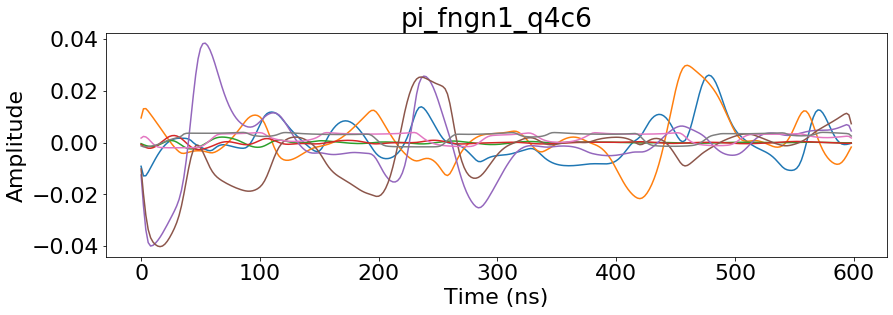

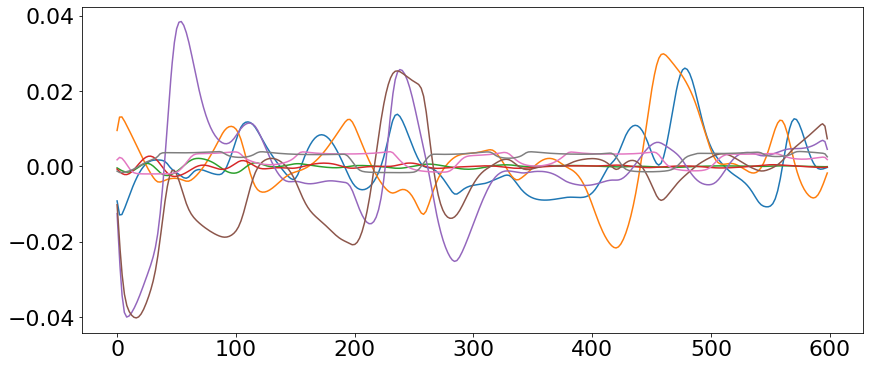

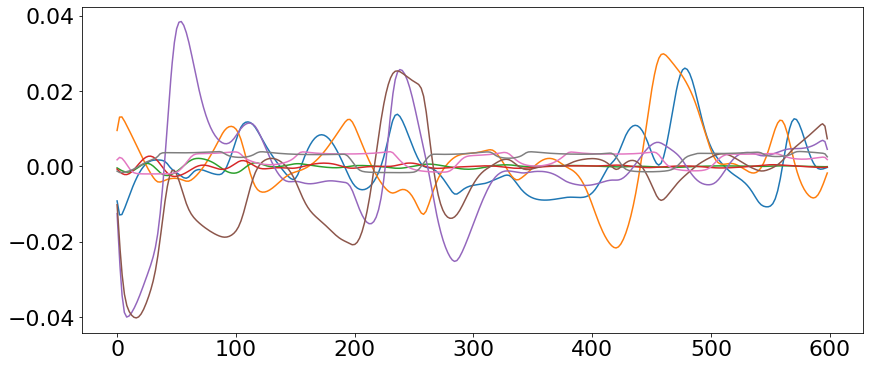

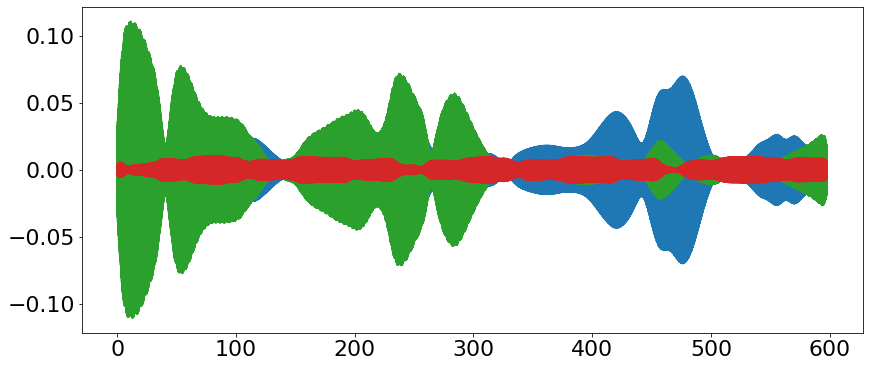

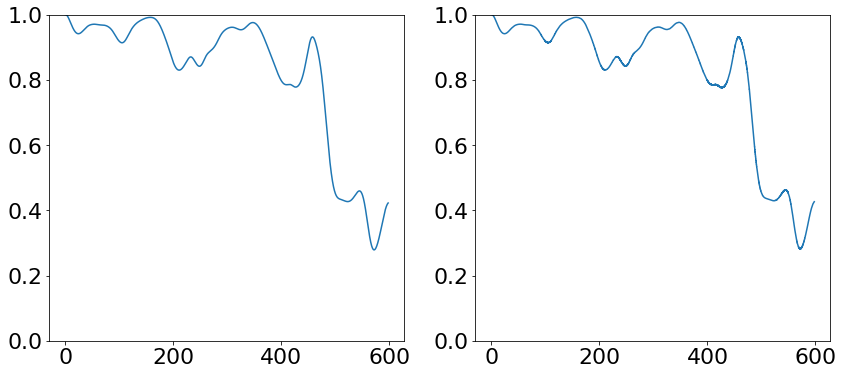

In [1]:
%matplotlib inline
import numpy as np
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
from qutip import *
from scipy import interpolate


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
from slab.dsfit import*
import json


expt_name = 'binomialcode_pi_fngn1'
expt_name = 'pi_fngn1_q4c6'
filelist = [21] 
nus = []


def labH(q_num, m_num, start_state, end_states, f, ROTATING):
    global fig_counter
    # Defining time scales, other parameters for lab drift Hamiltonian H0
    total_time = f['total_time'][()]
    steps = f['steps'][()]
    fine_steps = 30000
    base_times = np.arange(steps) * total_time / steps
    # subtract off the last step to not have fine_step times greater than the maximum base_time
    tlist = np.arange(fine_steps - fine_steps/steps) * total_time / fine_steps
    
    qubit_state_num = q_num
    alpha = 0.139
    freq_ge = 4.8 # GHz, in lab frame
    ens = np.array([2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
    Q_x = np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1)+np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1)
    Q_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1)-np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1))
    Q_z = np.diag(np.arange(0, qubit_state_num))
    I_q = np.identity(qubit_state_num)
    H_q = np.diag(ens)

    mode_state_num = m_num
    chi = -0.565e-3
    kappa = -chi / 10.0
    if ROTATING:
        mode_freq = 0.0  # GHz, in rotating frame
    else:
        mode_freq = 6.0  # GHz, in lab frame
    mode_ens = np.array([2*np.pi*ii*(mode_freq - 0.5*(ii-1)*kappa) for ii in np.arange(mode_state_num)])
    M_x = np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)+np.diag(np.sqrt(np.arange(1, mode_state_num)), -1)
    M_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)-np.diag(np.sqrt(np.arange(1, mode_state_num)), -1))
    M_z = np.diag(np.arange(0, mode_state_num))
    H_m = np.diag(mode_ens)
    I_m = np.identity(mode_state_num)

    # drift Hamiltonian (definition different in rotating vs. lab frame)
    if ROTATING:  # rotating frame Hamiltonian
        H0 = Qobj(np.kron(I_q, H_m) + 2 * 2 * np.pi * chi * np.kron(Q_z, M_z))  
    else:  # lab Hamiltonian
        H0 = Qobj(np.kron(H_q, I_m) + np.kron(I_q, H_m) + 2 * 2 * np.pi * chi * np.kron(Q_z, M_z))
    

    
    # define control Hamiltonians (definition may be different in rotating vs. lab frame)
    controlHs = []
    # qubit Pi pulses
    for state in range(qubit_state_num - 1):
        piX = np.zeros((qubit_state_num, qubit_state_num))
        piY = np.zeros((qubit_state_num, qubit_state_num)) * 1j
        piX[state][state + 1] = 1.0
        piX[state + 1][state] = 1.0
        piY[state][state + 1] = 0 + 1j
        piY[state + 1][state] = 0 - 1j
        controlHs.append(Qobj(np.kron(piX, I_m)))  # only have x-pulses in lab frame
        if ROTATING:
            controlHs.append(Qobj(np.kron(piY, I_m)))
    
    # fn-g(n+1) sideband
    fngnp1x = np.zeros((qubit_state_num * mode_state_num, qubit_state_num * mode_state_num))
    fngnp1y = np.zeros((qubit_state_num * mode_state_num, qubit_state_num * mode_state_num)) * 1j
    for n in range(mode_state_num - 1):
        fngnp1x[n+1][n+2*mode_state_num] = np.sqrt(n+1)
        fngnp1x[n+2*mode_state_num][n+1] = np.sqrt(n+1)
        fngnp1y[n+1][n+2*mode_state_num] = 1j * np.sqrt(n+1)
        fngnp1y[n+2*mode_state_num][n+1] = -1j * np.sqrt(n+1)
    controlHs.append(Qobj(fngnp1x))  # only have x-pulses in lab frame
    if ROTATING:
        controlHs.append(Qobj(fngnp1y))
    
    # put together drift and control Hamiltonians
    fig2 = plt.figure(fig_counter, figsize=(14,6))
    fig_counter += 1
    fine_pulses = []
    if ROTATING:
        for i in range(len(controlHs)):
            base_pulse = f['uks'][-1][i]  # final control pulse
            interpFun = interpolate.interp1d(base_times, base_pulse)
            pulse_interp = interpFun(tlist)
            fine_pulses.append(pulse_interp)
            plt.plot(tlist, pulse_interp)
    else:
        for i in range(2 * len(controlHs)):
            base_pulse = f['uks'][-1][i]  # final control pulse
            interpFun = interpolate.interp1d(base_times, base_pulse)
            pulse_interp = interpFun(tlist)
            fine_pulses.append(pulse_interp)
            plt.plot(tlist, pulse_interp)
    # fig2.show()
    
    if ROTATING:
        H = [H0]
        for index in range(len(fine_pulses)):
            H.append([controlHs[index], fine_pulses[index]])
    else:
        scale = 2
        # pi_ge qubit pulse
        amps_ge = scale * (fine_pulses[0] * np.cos(tlist * 2*np.pi * freq_ge) - \
                  fine_pulses[1] * np.sin(tlist * 2*np.pi* freq_ge))

        # pi_ef qubit pulse
        amps_ef = scale * (fine_pulses[2] * np.cos(tlist * 2*np.pi * (freq_ge - alpha)) - \
                  fine_pulses[3] * np.sin(tlist * 2*np.pi * (freq_ge - alpha)))

        # pi_fh qubit pulse
        amps_fh = scale * (fine_pulses[4] * np.cos(tlist * 2*np.pi * (freq_ge - 2 * alpha)) - \
                  fine_pulses[5] * np.sin(tlist * 2*np.pi * (freq_ge - 2 * alpha)))

        # fng(n+1) sideband pulse
        amps_fngn1 = scale * (fine_pulses[6] * np.cos(tlist * 2*np.pi * (2 * freq_ge - alpha - mode_freq)) - \
                        fine_pulses[7] * np.sin(tlist * 2*np.pi * (2 * freq_ge - alpha - mode_freq)))

        fig3 = plt.figure(fig_counter, figsize=(14,6))
        fig_counter += 1
        plt.plot(tlist, amps_ge)
        plt.plot(tlist, amps_ef)
        plt.plot(tlist, amps_fh)
        plt.plot(tlist, amps_fngn1)
        # fig3.show()

        H = [H0, [controlHs[0], amps_ge], [controlHs[1], amps_ef], [controlHs[2], amps_fh], [controlHs[3], amps_fngn1]]

    # starting state
    rho0 = start_state
    
    # define expectation values to look at
    e_ops = []
    for state in end_states:
        e_op = Qobj(np.diag(end_states))
        e_ops.append(e_op)
    result = mesolve(H, rho0, tlist, c_ops=[], e_ops=e_ops)
    #result_states = mesolve(H, rho0, tlist, c_ops=[], e_ops=[])
    return result, tlist


fig_counter = 1

for ii,i in enumerate(filelist):
    filename = "C:\Schuster Lab\Multimode\GRAPE-Tensorflow-Examples-master\pulses\output_pulses\\" + \
                str(i).zfill(5) + "_" + expt_name.lower()+".h5"

    with File(filename,'r') as a:
        print(a.keys())
        # get values that will be used in plotting
        # get scalar slice using [()]
        update_step = a['convergence']['update_step'][()]
        steps = a['steps'][()]
        dt = a['total_time'][()] / steps
        #print(a['wall_clock_time'][()])
        
        fig = plt.figure(1, figsize=(14,14))
        fig_counter += 1
        ax = fig.add_subplot(311, title=expt_name)
    
        # plot control pulses, last element is the final control pulse output
        for i in range(len(a['Hops'][()])):
            ax.plot(np.arange(0, steps) * dt, a['uks'][-1][i])
        #ax.plot(np.arange(0, steps) * dt, np.zeros(steps), '--k')  # plot a line y=0 for reference
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Amplitude")
        print(a['Hnames'][()])
        
        qubit_state_num = 4
        mode_state_num = 6
        
        start_state = np.zeros(qubit_state_num * mode_state_num)  # 4 qubit states, 6 cavity states
        start_state[5] = 1.0  # g5
        start_state = Qobj(start_state)

        f4 = np.zeros(qubit_state_num * mode_state_num)
        f4[2 * mode_state_num + 4] = 1
        end = f4
        output, tlist = labH(qubit_state_num, mode_state_num, start_state, end, a, True)
        output_rot, tlist_rot = labH(qubit_state_num, mode_state_num, start_state, end, a, False)
        fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(14,6))
        ax.plot(tlist, output.expect[0], label="f4")
        ax2.plot(tlist_rot, output_rot.expect[0], label="f4_rot")
        ax.set_ylim(0, 1)
        ax2.set_ylim(0, 1)
        print(output.expect[0][-1])
        print(str(1 - output.expect[0][-1]))
        print(output_rot.expect[0][-1])
        print(str(1 - output_rot.expect[0][-1]))
    
    
